Notes from JJ:

* btw you are querying an asteroid, not a KBO, which explains the weird movement! - cool!
* Keep the aladin widget but dont query that way - TODO: Get clarification on how then
* Get the results from SSOIS but then query CADC using the image and RA/DEC
* Use the cadc astroquery `get_url` function then do cutout from RA/DEC
* Have a plot that user can choose the date range
* Display KBOs along same axes, linking the views so when one moves, another moves, e.g. 

date 1 | date 2 | date 3
--- | --- | ---
KBO | KBO | KBO

* Have a circle around KBO - like quasar
* Allow user to click KBO, create `photoutils` aperture with pixels from 


# Interactive KBO Notebook

In [1]:
from ipyaladin import Aladin
from ipywidgets import Layout, Box, widgets
import pandas as pd
import astropy.units as u
from astropy.table import Table

In [ ]:
!jupyter nbextension enable --py widgetsnbextension
#!jupyter nbextension enable --py --sys-prefix ipyaladin

In [ ]:
aladin = Aladin(layout=Layout(width='100%', height='400px'), fov=20)

select_button = widgets.Button(description="Select")
def on_select_button_clicked(b):
    aladin.rectangular_selection()

    
select_button.on_click(on_select_button_clicked)
# query_button.on_click(on_query_button_clicked)

table_info = widgets.HTML(layout=Layout(height='auto', overflow='auto'))
#table_selection_list = []

box_layout = Layout(display='flex',
                    flex_flow='column wrap',
                    align_items='stretch',
                    justify_content='flex-start',
                    width='100%',
                    position='relative',
                    overflow='hidden',
                    height='80vh',
                    margin='-100px 0 0 0',
                    padding='100px 0 0 0 '
                   )
box = Box(children=[aladin, select_button, table_info], layout=box_layout)
box

In [ ]:
def process_result(sources):
    selection = pd.DataFrame([source['data'] for source in sources])
    #table_selection_list.append(selection)
    # Alternatively, just convert dict to pandas table and print - might look much better!
    table_info.value = selection[['Image', 'Object_Dec',  'Object_RA']].to_html()

aladin.add_listener('select', process_result)


In [7]:
# SSOIS query
# Search by object name
# Date Range Entered: 2006-09-01 to 2006-09-30
objects = ['Yasutani', '2006+RJ43', '45302', '6641+P-L']
url = ('https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl?lang=en&object={}'
       '&search=bynameCADC&epoch1=2006+09+01&epoch2=2006+09+30&eellipse=&eunits=arcseconds'
       '&extres=yes&xyres=yes;format=tsv').format(objects[3])
data_table = pd.read_csv(url, sep='\t')

# filter table with negative extension values
data_table = data_table[data_table['Ext'] > 0]

#coords_list = [SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs') for ra, dec in zip(data_table['Object_RA'], data_table['Object_Dec'])]
#hmsdms_str_list = [coords.to_string('hmsdms').split(' ') for coords in coords_list]
#data_table['Object_RA'], data_table['Object_Dec'] = list(zip(*hmsdms_str_list))

data_table.head()
table = Table.from_pandas(data_table)
#aladin.add_table(table)
#table

In [8]:
table

Image,Ext,X,Y,MJD,Filter,Exptime,Object_RA,Object_Dec,Image_target,Telescope/Instrument,MetaData,Datalink
str7,int64,float64,float64,float64,str8,int64,float64,float64,str6,str12,str69,float64
869870p,30,285.6,2805.2,53992.3966645426,G.MP9401,30,16.8555741361326,6.32166055369719,Main12,CFHT/MegaCam,http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/869870p[30],--
869882p,30,323.5,2842.5,53992.408535630995,G.MP9401,30,16.8532608567053,6.32249891634057,Main12,CFHT/MegaCam,http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/869882p[30],--
869894p,30,346.3,2855.1,53992.419775212,G.MP9401,30,16.8510706370213,6.3232926805275795,Main12,CFHT/MegaCam,http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/869894p[30],--
869906p,30,386.6,2875.7,53992.431291730994,G.MP9401,30,16.8488264513521,6.3241060026916305,Main12,CFHT/MegaCam,http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/869906p[30],--
869918p,30,427.1,2894.8,53992.4427910773,G.MP9401,30,16.8465856120699,6.32491811208139,Main12,CFHT/MegaCam,http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/869918p[30],--
869930p,30,462.8,2923.9,53992.4546321005,G.MP9401,30,16.8442781913499,6.32575435145283,Main12,CFHT/MegaCam,http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/869930p[30],--
869942p,30,498.1,2925.6,53992.4659541947,G.MP9401,30,16.8420718925934,6.326553942905459,Main12,CFHT/MegaCam,http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/869942p[30],--
869954p,30,543.2,2949.8,53992.4779011889,G.MP9401,30,16.839743821657,6.3273976661847495,Main12,CFHT/MegaCam,http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/869954p[30],--
869966p,30,581.0,2968.9,53992.489347029405,G.MP9401,30,16.837513408871402,6.3282059968760995,Main12,CFHT/MegaCam,http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/869966p[30],--


In [9]:
from astroquery.cadc import Cadc

# ra_list, dec_list, mjd_list = table_selection['Object_RA'], table_selection['Object_Dec'], table_selection['MJD']
# ext_list = table_selection['Ext']
table.rename_column('Image', 'productID')
productId_list = "', '".join(table['productID'])

query = '''SELECT *
FROM caom2.Plane AS Plane 
JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID 
WHERE ( Plane.productID IN ('{}') )
ORDER BY time_bounds_lower ASC'''.format(productId_list)
cadc = Cadc()
job = cadc.run_query(query, 'sync')
results = job.get_results()

cols = [
 'calibrationLevel',
 'position_bounds',
 'position_bounds_size',
 'position_sampleSize',
 'position_dimension_naxis1',
 'position_dimension_naxis2',
 'obsID',
 'planeID',
 'productID',
 'dataProductType',
 'quality_flag',
 'position_bounds_points',
 'proposal_keywords',
 'collection',
 'type',
 'target_name',
 'telescope_name',
 'time_bounds_lower']

results[cols]

calibrationLevel,position_bounds,position_bounds_size,position_sampleSize,position_dimension_naxis1,position_dimension_naxis2,obsID,planeID,productID,dataProductType,quality_flag,position_bounds_points,proposal_keywords,collection,type,target_name,telescope_name,time_bounds_lower
,deg,deg,arcsec,,,,,,,,deg,,,,,,d
int32,object,float64,float64,int64,int64,bytes36,bytes36,bytes64,bytes128,bytes16,object,object,bytes32,bytes32,bytes32,bytes32,float64
2,[17.089044308686464 6.179624184699989 16.102294508268866 6.175765189727662 16.097523694475832 7.1662126451615995 16.207496294384118 7.1726066347764235 17.088469488471336 7.17754910258159],1.4010581571637863,0.186124380919742,18960,19288,00000000-0000-0000-d4a7-013ed27e3900,00000000-0000-0000-16dd-013ed281f9e0,869870p,image,,[17.089044308686457 6.179624184699989 16.102294508268844 6.175765189727656 16.097523694475836 7.166212645161593 16.207496294384143 7.172606634776415 17.088469488471343 7.177549102581608],,CFHT,OBJECT,Main12,CFHT 3.6m,53992.3964907
2,[17.08680792324209 7.169327594766717 17.088182765663575 6.178778578955335 16.103033843988143 6.175641983503534 16.097523694475832 7.1662126451615995 16.97658373792005 7.174342410670307],1.3939799245011717,0.18603218540449784,18944,19226,00000000-0000-0000-fdaf-013ed27e3e62,00000000-0000-0000-af94-013ed2827ded,869882p,image,,[17.086807923242077 7.169327594766699 17.088182765663568 6.178778578955345 16.10303384398813 6.175641983503539 16.09752369447582 7.166212645161593 16.976583737920052 7.174342410670292],,CFHT,OBJECT,Main12,CFHT 3.6m,53992.4083618
2,[17.086670749275502 6.1788494744227425 16.10192410471798 6.168266882869949 16.097523694475832 7.1662126451615995 17.084542070816205 7.173698078762894],1.4012132393008745,0.18603657249693065,18915,19358,00000000-0000-0000-9729-013ed27eea40,00000000-0000-0000-7761-013ed28294dd,869894p,image,,[17.086670749275477 6.178849474422719 16.10192410471799 6.168266882869958 16.097523694475836 7.166212645161593 17.084542070816227 7.173698078762911],,CFHT,OBJECT,Main12,CFHT 3.6m,53992.4196013
2,[17.08644182490072 6.178730356804927 16.10192410471798 6.168266882869949 16.097069533628247 7.169911415565479 17.084946054769546 7.173407989537367],1.4012848509702989,0.18600928684540355,18919,19353,00000000-0000-0000-6ac3-013ed27ff52e,00000000-0000-0000-28e2-013ed282e247,869906p,image,,[17.086441824900714 6.178730356804934 16.101924104717966 6.168266882869958 16.097069533628243 7.169911415565494 17.084946054769542 7.173407989537381],,CFHT,OBJECT,Main12,CFHT 3.6m,53992.4311179
2,[17.09023544093668 6.1716700786633565 16.101375217012983 6.175583331346593 16.096894126818416 7.170282922285291 17.08710654735683 7.176290862980157],1.4037939181544752,0.18606638378128082,18995,19342,00000000-0000-0000-179f-013ed2828efe,00000000-0000-0000-84cb-013ed285d2a1,869918p,image,,[17.090235440936684 6.171670078663368 16.101375217012972 6.175583331346601 16.096894126818402 7.17028292228531 17.087106547356836 7.176290862980167],,CFHT,OBJECT,Main12,CFHT 3.6m,53992.4426172
2,[17.086186307313085 6.177582784339037 16.980911410111567 6.170591584795881 16.101391112741805 6.174954721637882 16.096569905653407 7.169101927727475 17.086637227332847 7.175617083440133],1.3996131808634202,0.18597880826348204,18923,19353,00000000-0000-0000-3d38-013ed2836b5d,00000000-0000-0000-40bf-013efe50b43d,869930p,image,,[17.08618630731311 6.177582784339009 16.98091141011156 6.170591584795872 16.101391112741812 6.174954721637903 16.096569905653382 7.169101927727482 17.08663722733285 7.1756170834401445],,CFHT,OBJECT,Main12,CFHT 3.6m,53992.4544582
2,[17.08564893322855 6.178501927180807 16.10192410471798 6.168266882869949 16.096160815956672 7.17028370997764 17.083661316252822 7.173467413024072],1.400438660041335,0.186125836699184,18921,19353,00000000-0000-0000-29f7-013ed28525d7,00000000-0000-0000-0ef0-013ed288a5b1,869942p,image,,[17.08564893322858 6.178501927180804 16.101924104717988 6.168266882869943 16.096160815956672 7.170283709977625 17.083661316252826 7.173

In [10]:
from astropy.table import Table, join

joined_table = join(table, results, keys='productID')


In [11]:
urls = cadc.get_data_urls(joined_table)
joined_table['url'] = urls

urls[0:5]

['https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/869870p.fits.fz?RUNID=s9aipcteda96oo7d',
 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/869882p.fits.fz?RUNID=zj55bpvaxkiihub6',
 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/869894p.fits.fz?RUNID=k07w0u9kkdr8o8ia',
 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/869906p.fits.fz?RUNID=pjsbl2ol2b8itc30',
 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/869918p.fits.fz?RUNID=byqwe6ccbdlk35yc']

In [13]:
from astropy.time import Time, TimeDelta
import numpy as np
import math

start_date = math.floor(results['time_bounds_lower'].min())
end_date = math.ceil(results['time_bounds_lower'].max())

dates = Time(np.arange(start_date, end_date, 1), format='mjd', out_subfmt='date')
options = [(' {} '.format(date.iso), date.mjd) for date in dates]
range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=(1,5), #TODO: Should check that this is not more than length of list
    description='Date Range:',
    disabled=False,
)

range_slider.layout.width = '800px'
range_slider



SelectionRangeSlider(description='Date Range:', index=(1, 5), layout=Layout(width='800px'), options=((' 2006-0…

TypeError: ceil() takes exactly one argument (2 given)

In [17]:
from astropy.coordinates import SkyCoord

def get_selection(table, date_range):
    return table[(results['time_bounds_lower'] > date_range[0]) & 
                        (results['time_bounds_lower'] < date_range[1])]

def get_cutout_params(table):
    ra_max, ra_min = table['Object_RA'].max(), table['Object_RA'].min()
    dec_max, dec_min = table['Object_Dec'].max(), table['Object_Dec'].min()

    ra_centre = (ra_max + ra_min)/2 
    dec_centre = (dec_max + dec_min)/2

    ra_radius =  abs(ra_max - ra_min)/2 
    dec_radius =  abs(dec_max - dec_min)/2

    radius = round(max(ra_radius, dec_radius), 2)
    
    return ra_centre, dec_centre, radius

selection = get_selection(joined_table, range_slider.value)
ra, dec, radius = get_cutout_params(selection)


In [18]:
import re
from astropy.wcs import WCS
from astropy.io import fits
import urllib

def get_cutout_urls(url, ra, dec, radius=0.01, verbose=False):
    uri = 'ad:' + \
        re.findall(
            "https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/(.+)\?RUNID=", url)[0]

    cutout_region_string = 'Circle ICRS {ra} {dec} {radius}'.format(
        ra=ra, dec=dec, radius=radius)
    params_dict = {'uri': uri, 'cutout': cutout_region_string}

    base_url = 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/cutout'

    url_params = urllib.parse.urlencode(params_dict)
    data_url = '{}?{}'.format(base_url, url_params)
    return data_url


cutout_urls = [get_cutout_urls(url, ra, dec, radius=radius) for url in selection['url']]
selection['cutout_url'] = cutout_urls
#data_list = [get_cutout_image_data(url, ra_centre, dec_centre, radius=radius) for url in urls]


In [35]:
ra, dec, radius = get_cutout_params(joined_table)
cutout_urls = [get_cutout_urls(url, ra, dec, radius=radius) for url in joined_table['url']]
joined_table['cutout_url'] = cutout_urls


In [28]:
data_list = []
for cutout_url in selection['cutout_url']:
    with fits.open(cutout_url, ignore_missing_end=True) as hdulist:
        hdulist.info()
        data = hdulist[1].data

Filename: /home/badune/.astropy/cache/download/py3/b294271d11f7783f9a1ae4d06b1176e0
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     394   ()      
  1  ccd11        11 ImageHDU       432   (231, 388)   int16 (rescales to float32)   
  2  ccd12        12 ImageHDU       432   (149, 388)   int16 (rescales to float32)   
Filename: /home/badune/.astropy/cache/download/py3/e68f7c091653c209970b5eaf4bdb36ff
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     394   ()      
  1  ccd11        11 ImageHDU       432   (265, 388)   int16 (rescales to float32)   
  2  ccd12        12 ImageHDU       432   (118, 388)   int16 (rescales to float32)   
Filename: /home/badune/.astropy/cache/download/py3/c139db3353fba314ff6980d349e4e2af
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     394   ()      
  1  ccd11        11 ImageHDU       432   (218, 388)   int16 (res

<IPython.core.display.Javascript object>


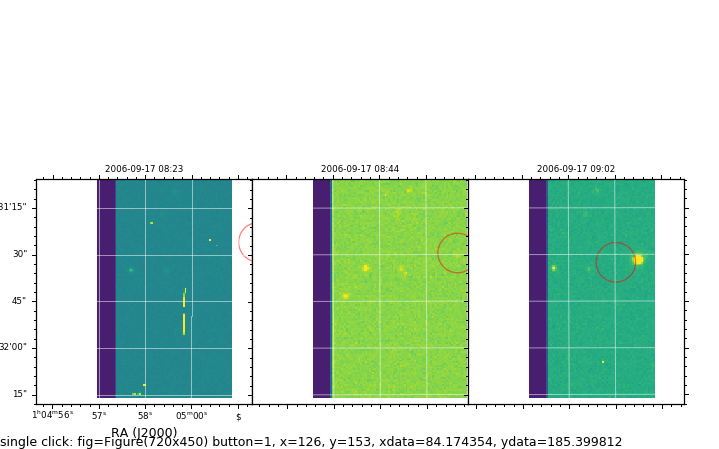

INFO: Auto-setting vmin to -2.535e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.813e+02 [aplpy.core]
INFO: Auto-setting vmin to -1.242e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.379e+02 [aplpy.core]
INFO: Auto-setting vmin to -1.683e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.868e+02 [aplpy.core]


In [113]:
%matplotlib notebook
import aplpy
import matplotlib.pyplot as plt
import warnings

def make_figure(selection):
    fig = plt.figure(figsize=(8, 5))
    #https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/axes_zoom_effect.html#sphx-glr-gallery-subplots-axes-and-figures-axes-zoom-effect-py
    # TODO: Add circles around KBO
    # TODO: Remove axes text
    idx = 0
    text=fig.text(0,0, "", va="bottom", ha="left")
    center = None
    
    def onclick(event):
        if event.dblclick:
            circle = plt.Circle((event.xdata, event.ydata), 2.5, color='black')
            fig.add_artist(circle)
            fig.canvas.draw()
            
        tx = ('%s click: fig=%s button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
              ('double' if event.dblclick else 'single', event.canvas.figure, event.button,
               event.x, event.y, event.xdata, event.ydata))
        center = (event.xdata, event.ydata)
        text.set_text(tx)
        
    def onrelease(event):
        tx = ('%s release: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
              ('double' if event.dblclick else 'single', event.button,
               event.x, event.y, event.xdata, event.ydata))
        radius = math.sqrt((center[0] - event.xdata)**2 + (center[1] - event.ydata)**2)
        point2 = (event.xdata, event.ydata)
        text.set_text('point 2: {} '.format(point2))
        
    cid_press = fig.canvas.mpl_connect('button_press_event', onclick)
    cid_release = fig.canvas.mpl_connect('button_release_event', onrelease)

    for cutout_url, ra, dec, date in zip(selection['cutout_url'], selection['Object_RA'], selection['Object_Dec'], selection['time_bounds_lower']):
        try:
            with fits.open(cutout_url, ignore_missing_end=True) as hdulist:
                w = 0.9/len(selection)
                f = aplpy.FITSFigure(hdulist, figure=fig,downsample=3, hdu=1, subplot=[0.05 + (w*idx), 0.1, w, 0.5])
                if idx:
                    f.axis_labels.hide()
                    f.tick_labels.hide()
                else:
                    
                    f.tick_labels.set_font(size='x-small', weight='medium', \
                         stretch='normal', family='sans-serif', \
                         style='normal', variant='normal')
                    #f.ticks.set_length(3)
               # f.ticks.set_xspacing(0.02)
                f.show_colorscale()
                f.add_grid()
                f.grid.set_alpha(0.5)
                f.show_circles(ra, dec, 0.1, coords_frame='world', facecolor='none', edgecolor='red')
                f.show_markers(ra, dec, edgecolor='red', facecolor='none', marker='o', s=1000, alpha=0.5)
                f.set_title(Time(date, format='mjd', out_subfmt='date_hm').iso, fontsize='x-small')
                
                idx+=1
        except ValueError as ex:
            print('Value Error: %s' % ex)
            continue


    axes = fig.get_axes()
    axes[0].get_shared_x_axes().join(*axes)
    axes[0].get_shared_y_axes().join(*axes)

    fig.canvas.draw()
    
# Supress fits processing warnings
warnings.simplefilter('ignore')

make_figure(selection[0:3])


In [56]:
selection['Object_RA']

16.2518491696819
16.2486435546532
16.2459042245858
16.243179535476198
16.2404515808903
16.2377490096083
16.23498578686
16.232225308311698
16.229456029558598
16.2267227551526


In [ ]:
%matplotlib notebook
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import LinearStretch, ImageNormalize, ZScaleInterval

np.seterr(divide='ignore', invalid='ignore')

def plot_image_list_same_axes(data_list, geo=None):
    """ Plot the kbos together"""

    # need to get wcs range???
    plt.figure(figsize=(9, 7))
    plt.title('KBOs???', fontsize=14, fontweight='bold', y=0.94)
    
    wcs_proj = data_list[0]['wcs'] #TODO: Build own wcs projection?
    ax = plt.subplot(projection=wcs_proj)
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
# #     ax.set_xlim(xlim[0] - 1, xlim[1] + 1)
# #     ax.set_ylim(ylim[0] - 1, ylim[1] + 1)
#     ax.set_xlim(-150, 450)
#     ax.set_ylim(-250, 250)
    for idx, (data, x, y) in enumerate(zip(data_list, x_list, y_list)):

        image_data_norm = ImageNormalize(data['image_data'],
                                         interval=ZScaleInterval(),
                                         stretch=LinearStretch())

        plt.imshow(data['image_data'], transform=ax.get_transform(data['wcs']), 
                   norm=image_data_norm, cmap='gray', alpha=0.4)
#     # recompute the ax.dataLim
#     ax.relim()
#     # update ax.viewLim using the new dataLim
#     ax.autoscale_view() 


#TODO: Make have if one moves, others move
#TODO: Add ability to filter by date range
def plot_image_list_same_wcs(data_list, geo=None):
    """ Plot the kbos together"""

    fig = plt.figure(figsize=(20, 10))
    plt.title('KBOs???', fontsize=14, fontweight='bold', y=0.94)
    if geo is None:
        geo = (2, len(data_list)/2)  # nrows, ncols
    wcs_proj = data_list[0]['wcs']
    ax = plt.subplot(projection=wcs_proj)

    for idx, data in enumerate(data_list):
        ax = plt.subplot(geo[0], geo[1], idx + 1, projection=wcs_proj)
        ax.coords.grid(color='white', ls='solid')
        image_data_norm = ImageNormalize(data['image_data'],
                                         interval=ZScaleInterval(),
                                         stretch=LinearStretch())

        ax.imshow(data['image_data'], transform=ax.get_transform(data['wcs']), norm=image_data_norm, cmap='gray')
        



plot_image_list_same_wcs(data_list_filtered)

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import LinearStretch, ImageNormalize, ZScaleInterval

#TODO: Talk to Seb about plots
def plot_image_list(data_list,  x_list, y_list, geo=None):

    if geo is None:
        geo = (1, len(data_list))  # nrows, ncols

    fig = plt.figure(figsize=(20, 10))
    for idx, (data, x, y) in enumerate(zip(data_list, x_list, y_list)):
        image_data, wcs = data['image_data'], data['w']
        ax = plt.subplot(geo[0], geo[1], idx + 1, projection=wcs)
        image_data_norm = ImageNormalize(image_data,
                                         interval=ZScaleInterval(),
                                         stretch=LinearStretch())

        ax.imshow(image_data, norm=image_data_norm, cmap='gray')
        ax.coords.grid(color='white', ls='solid')
        ra, dec = ax.coords['ra'], ax.coords['dec']
        ra.set_ticklabel_position('lb')
        dec.set_ticklabel_position('lb')
        ra.set_axislabel('Right Ascension')
        dec.set_axislabel('Declination')


plot_image_list(data_list, x_list, y_list)

In [ ]:
url = 'data/idhc02xaq_flt.0____1________2________3________4________5________6_.fits'
url2 = 'data/idhc02xaq_flt.1________2________3________4________5_____.fits'
%matplotlib inline
from astropy.io import fits

with fits.open(url) as hdul:
    hdul.info()
    data = hdul[1].data
    
plt.imshow(data)

In [ ]:
import re
from math import ceil
import requests
from astropy.wcs import WCS
from astropy.io import fits

def get_cutout_image_data(url, ra, dec, radius=0.01, ext=0, verbose=False):
    """Given a data url and coordinates, returns the image data and wcs 
    coordinate data of a fits file at the given extension, cutout around the url"""

    uri = 'ad:' + \
        re.findall(
            "https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/(.+)\?RUNID=", url)[0]

    cutout_region_string = 'Circle ICRS {ra} {dec} {radius}'.format(
        ra=ra, dec=dec, radius=radius)
    params_dict = {'uri': uri, 'cutout': cutout_region_string}

    base_url = 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/cutout'

    url_params = urllib.parse.urlencode(params_dict)
    data_url = '{}?{}'.format(base_url, url_params)
    try:
        with fits.open(data_url, ignore_missing_end=True) as hdulist:
            if verbose:
                hdulist.info()
            w = WCS(hdulist[ext].header)
            image_data = hdulist[ext].data
        return {'image_data': image_data, 'wcs': w}
    except:
        print('Error: Problem with {}'.format(data_url))
        return None

def download_url_to_file(url, cutout=None, data_dir='data'):
    '''Takes a url, downloads the resource, saves it in the data directory with the
    name specified in the response Content Disposition, and returns the file path and name'''

    def get_filename_from_response(response):
        content_disposition = response.headers['Content-Disposition']
        return re.findall("filename=(.+)", content_disposition)[0]

    resp = requests.get(url, params={'cutout': cutout}) if cutout else requests.get(url)
    fname = get_filename_from_response(resp)
    file_name_and_path = '{data_dir}/{fname}'.format(data_dir=data_dir, fname=fname)
    # Note: wb will overwrite if something is already there
    with open(file_name_and_path, 'wb') as f:
        f.write(resp.content)
        
    return file_name_and_path
def get_fits_data_from_file(fname, ext=0, verbose=False):
     with fits.open(fname, ignore_missing_end=True) as hdulist:
        if verbose:
            hdulist.info()
        w = WCS(hdulist[ext].header)
        image_data = hdulist[ext].data
        return {'image_data': image_data, 'w': w}   

def get_fits_data_from_url(data_url, pos=None, ext=0,  offset=200, verbose=False):
    # TODO: Make offset or 0/max_pixel if overflow
    # Lets grab the header first? check if cutout is largers than axes
    if pos:
        x, y = pos[0], pos[1]
        hdr = fits.getheader(data_url, 0)
        x_fits_max = hdr['NAXIS1']
        y_fits_max = hdr['NAXIS2']
        x_min, x_max = ceil(x-offset), ceil(x+offset) if ceil(x+offset) < x_fits_max else x_fits_max
        y_min, y_max = ceil(y-offset), ceil(y+offset) if ceil(y+offset) < y_fits_max else y_fits_max
        url = data_url + '[{}:{},{}:{}]'.format(x_min, x_max, y_min, y_max)
    else:
        url = data_url
    try:
        with fits.open(url, ignore_missing_end=True) as hdulist:
            if verbose:
                print(cutout_url)
                hdulist.info()
            w = WCS(hdulist[ext].header)
            image_data = hdulist[ext].data
            return {'image_data': image_data, 'w': w}
    except TypeError:
        return None
    

urls = list(table_selection['MetaData'])
x_list, y_list = table_selection['X'], table_selection['Y']

#fname = download_url_to_file(urls[0])
#fname = 'data/869869p.20.fits'
#background = get_fits_data_from_file(fname)

data_list = [get_fits_data_from_url(urls[0])] + [get_fits_data_from_url(url, pos=(x, y)) for url, x, y in zip(urls, x_list, y_list)]